In [ ]:
# Notebook for reading in processed swot pixc data and plotting


In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import glob
import rasterio

In [2]:
import os
import numpy as np
from rasterio.enums import Resampling

def mean_raster(raster_files, output_path):
    """
    Compute the mean of all raster files in a directory and save as a GeoTIFF.
    Handles NoData values and large rasters efficiently.
    """

    if not raster_files:
        raise FileNotFoundError("No files provided.")

    # Open first raster to get metadata
    with rasterio.open(raster_files[0]) as src0:
        meta = src0.meta.copy()
        nodata_value = src0.nodata
        if nodata_value is None:
            nodata_value = np.nan  # Treat missing nodata as NaN

    # Prepare accumulators
    sum_array = None
    count_array = None

    # Process rasters one by one
    for idx, raster_path in enumerate(raster_files, start=1):
        with rasterio.open(raster_path) as src:
            data = src.read(1, masked=True)  # Read as masked array
            if sum_array is None:
                sum_array = np.zeros(data.shape, dtype=np.float64)
                count_array = np.zeros(data.shape, dtype=np.uint32)

            # Add valid values to sum and count
            valid_mask = ~data.mask
            sum_array[valid_mask] += data.data[valid_mask]
            count_array[valid_mask] += 1

        print(f"Processed {idx}/{len(raster_files)}: {os.path.basename(raster_path)}")

    # Compute mean, avoiding division by zero
    mean_array = np.divide(sum_array, count_array, out=np.full_like(sum_array, np.nan), where=count_array != 0)

    # Save output raster
    meta.update(dtype=rasterio.float32, nodata=np.nan, compress='lzw')
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(mean_array.astype(np.float32), 1)

    print(f"Mean raster saved to: {output_path}")

['C:\\Users\\safr\\Documents\\test_altimetry_project\\data\\swot\\processed\\raster\\2023-07-28_res100_heightEGM.tif',
 'C:\\Users\\safr\\Documents\\test_altimetry_project\\data\\swot\\processed\\raster\\2023-08-02_res100_heightEGM.tif',
 'C:\\Users\\safr\\Documents\\test_altimetry_project\\data\\swot\\processed\\raster\\2023-08-07_res100_heightEGM.tif',
 'C:\\Users\\safr\\Documents\\test_altimetry_project\\data\\swot\\processed\\raster\\2023-09-17_res100_heightEGM.tif',
 'C:\\Users\\safr\\Documents\\test_altimetry_project\\data\\swot\\processed\\raster\\2023-09-28_res100_heightEGM.tif',
 'C:\\Users\\safr\\Documents\\test_altimetry_project\\data\\swot\\processed\\raster\\2023-10-04_res100_heightEGM.tif',
 'C:\\Users\\safr\\Documents\\test_altimetry_project\\data\\swot\\processed\\raster\\2023-10-08_res100_heightEGM.tif',
 'C:\\Users\\safr\\Documents\\test_altimetry_project\\data\\swot\\processed\\raster\\2023-10-15_res100_heightEGM.tif',
 'C:\\Users\\safr\\Documents\\test_altimetry_pro

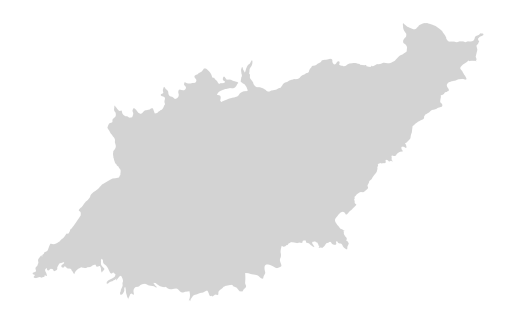

In [3]:
filenames = glob.glob("C:\\Users\\safr\\Documents\\test_altimetry_project\\data\\swot\\processed\\raster\\*heightEGM.tif")

wetland_utm = gpd.read_file("C:\\Users\\safr\\Documents\\test_altimetry_project\\shapefiles\\wetland_fans_domain_37S.shp")
wetland_ll = wetland_utm.to_crs("EPSG:4326")
ax_map = wetland_ll.plot(color='lightgray', edgecolor='none')
ax_map.set_axis_off()
filenames

In [103]:
##### Create frequency map of all height observations

# first create weekly aggregate maps of height observations
startdate = '2023-07-01'
enddate = '2026-01-31'
freq = '1MS'  # 7D,  1MS, frequency
period_str = 'monthly' # could be 'weekly' or 'monthly'

date_range = pd.date_range(start=startdate, end=enddate, freq=freq)

occurances = pd.DataFrame()
occurances['id'] = range(len(date_range)-1)
occurances['start'] = date_range[:-1]
occurances['end'] = (date_range[1:] - pd.Timedelta(days=1)).strftime('%Y-%m-%d')
occurances['num_files'] = 0

os.makedirs(f"C:\\Users\\safr\\Documents\\test_altimetry_project\\data\\swot\\processed\\raster\\{period_str}", exist_ok=True)


for i in range(len(date_range)-1):

    # dates in filenames formated like YYYY-MM-DD
    start_period = date_range[i].strftime('%Y-%m-%d') # dates in filenames formated like YYYY-MM-DD
    end_period = (date_range[i+1] - pd.Timedelta(days=1)).strftime('%Y-%m-%d')

    # get list of dates for this week
    all_dates = pd.date_range(start=start_period, end=end_period, freq='D').strftime('%Y-%m-%d').tolist()
    
    # create list of files for this week
    obs_files = [f for f in filenames if any(date in f for date in all_dates)]
    occurances.at[i, 'num_files'] = len(obs_files)

    if occurances.at[i, 'num_files'] == 0:
        continue
    # read in each file for the week and aggregate height observations
    # start an empty raster for aggregating height observations
    mean_raster(obs_files, f"C:\\Users\\safr\\Documents\\test_altimetry_project\\data\\swot\\processed\\raster\\{period_str}\\{period_str}_mean_height_{start_period}_to_{end_period}.tif")
        
    # (code to read and aggregate height observations goes here)


Processed 1/1: 2023-07-28_res100_heightEGM.tif
Mean raster saved to: C:\Users\safr\Documents\test_altimetry_project\data\swot\processed\raster\monthly\monthly_mean_height_2023-07-01_to_2023-07-31.tif
Processed 1/2: 2023-08-02_res100_heightEGM.tif
Processed 2/2: 2023-08-07_res100_heightEGM.tif
Mean raster saved to: C:\Users\safr\Documents\test_altimetry_project\data\swot\processed\raster\monthly\monthly_mean_height_2023-08-01_to_2023-08-31.tif
Processed 1/2: 2023-09-17_res100_heightEGM.tif
Processed 2/2: 2023-09-28_res100_heightEGM.tif
Mean raster saved to: C:\Users\safr\Documents\test_altimetry_project\data\swot\processed\raster\monthly\monthly_mean_height_2023-09-01_to_2023-09-30.tif
Processed 1/6: 2023-10-04_res100_heightEGM.tif
Processed 2/6: 2023-10-08_res100_heightEGM.tif
Processed 3/6: 2023-10-15_res100_heightEGM.tif
Processed 4/6: 2023-10-19_res100_heightEGM.tif
Processed 5/6: 2023-10-25_res100_heightEGM.tif
Processed 6/6: 2023-10-29_res100_heightEGM.tif
Mean raster saved to: C:

In [104]:
occurances

,id,start,end,num_files
0,0,2023-07-01,2023-07-31,1
1,1,2023-08-01,2023-08-31,2
2,2,2023-09-01,2023-09-30,2
3,3,2023-10-01,2023-10-31,6
4,4,2023-11-01,2023-11-30,6
5,5,2023-12-01,2023-12-31,4
6,6,2024-01-01,2024-01-31,5
7,7,2024-02-01,2024-02-29,5
8,8,2024-03-01,2024-03-31,5
9,9,2024-04-01,2024-04-30,5


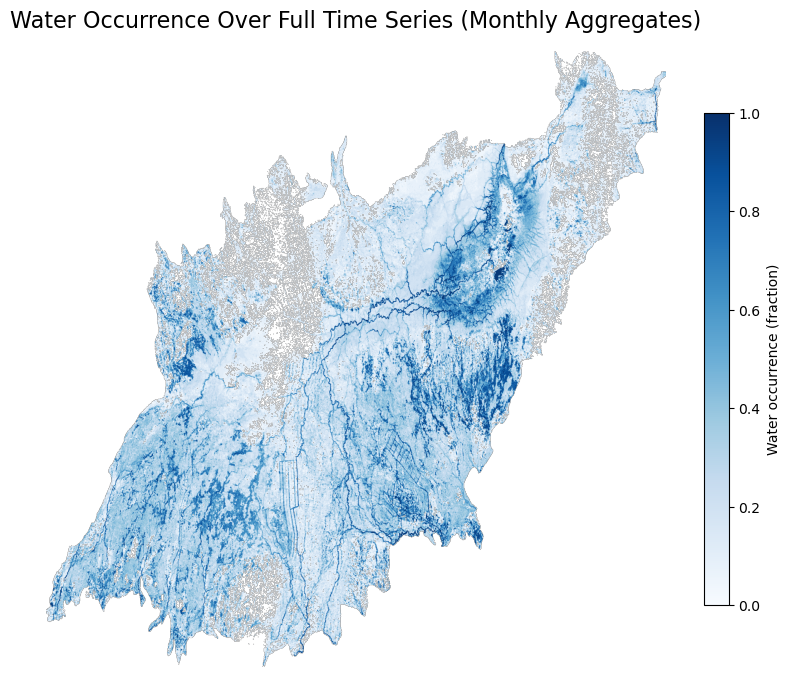

In [105]:
# Create occurance maps with weekly products

obs_files = glob.glob(
    rf"C:\Users\safr\Documents\test_altimetry_project\data\swot\processed\raster\{period_str}\{period_str}_mean_height_*.tif"
)

presence_stack = []

for obs_file in obs_files:
    with rasterio.open(obs_file) as src:
        data = src.read(1, masked=True)

        # Water presence: True where pixel has a valid value
        presence = ~data.mask
        presence_stack.append(presence)

        # Save metadata from first raster
        if len(presence_stack) == 1:
            meta = src.meta.copy()

presence_stack = np.stack(presence_stack, axis=0)
n_timestamps = presence_stack.shape[0]

# Fraction of weeks with water
occurrence = presence_stack.sum(axis=0) / (n_timestamps)

meta.update(
    dtype="float32",
    count=1,
    nodata=0.0
)

out_path = rf"C:\Users\safr\Documents\test_altimetry_project\data\swot\processed\raster\{period_str}\{period_str}_water_occurrence.tif"

with rasterio.open(out_path, "w", **meta) as dst:
    dst.write(occurrence.astype("float32"), 1)

# plot occurrence map

with rasterio.open(out_path) as src:
    occ = src.read(1)
    bounds = src.bounds

occ_masked = np.ma.masked_where(occ == 0, occ)

fig, ax = plt.subplots(figsize=(10, 8))

wetland_ll.plot(
    ax=ax,
    edgecolor='lightgray'
)

cax = ax.imshow(
    occ_masked,
    cmap="Blues",
    extent=bounds,     # (xmin, xmax, ymin, ymax)
    origin="upper",
    vmin=0,
    vmax=1
)
ax.set_axis_off()
ax.set_title("Water Occurrence Over Full Time Series"+f" ({period_str.capitalize()} Aggregates)", fontsize=16)

fig.colorbar(
    cax,
    ax=ax,
    label="Water occurrence (fraction)",
    shrink=0.8
)

plt.show()

In [106]:
# Now create two functions

# 1) computes total flooded extent over time

# 2) copmutes height timeseries for a provided coordinate (lat, lon), taking a small buffer around the point and averaging values within the buffer


def compute_flooded_extent(raster_file):
    """
    Compute total flooded extent for a given raster file
    A pixel is considered flooded if it is unmasked in the raster, later can include a threshold based on water_frac value
    
    Returns:
        Total flooded extent in square meters
    """
    with rasterio.open(raster_file) as src:
        data = src.read(1, masked=True)
        pixel_area = abs(src.transform.a * src.transform.e)  # pixel width * pixel height

        # Count flooded pixels
        flooded_pixels = np.sum(~data.mask)
        total_flooded_extent = flooded_pixels * pixel_area

    return total_flooded_extent

def extract_raster_height_from_latlon(utm_y, utm_x, raster_file, buffer_size=0):
    """
    Return the height value from the raster at the given UTM coordinate. If buffer_size > 0, average the height values within the buffer (in METERS).
    pixel_res : pixel resolution in meters
    """
    with rasterio.open(raster_file) as src:
        # Transform lat/lon to raster coordinates
        row, col = src.index(utm_x, utm_y)
        pixel_res_x = src.transform.a  # pixel width
        pixel_res_y = -src.transform.e  # pixel height (negative because of coordinate system)
        if pixel_res_x != pixel_res_y:
            raise ValueError("Non-square pixels are not supported.")
        
        if buffer_size > 0:
            # Calculate buffer in pixels
            buffer_pixels = int(buffer_size / pixel_res_x)

            # Define window
            window = rasterio.windows.Window(
                col - buffer_pixels,
                row - buffer_pixels,
                2 * buffer_pixels + 1,
                2 * buffer_pixels + 1
            )

            data = src.read(1, window=window, masked=True)
            mean_height = data.mean()
            return mean_height
        else:
            data = src.read(1, window=rasterio.windows.Window(col, row, 1, 1), masked=True)
            return data[0, 0]  # single value
        
# test functions
raster_file = "C:\\Users\\safr\\Documents\\test_altimetry_project\\data\\swot\\processed\\raster\\weekly\\weekly_mean_height_2024-04-07_to_2024-04-13.tif"
flooded_extent = compute_flooded_extent(raster_file)
print(f"Total flooded extent: {flooded_extent/1e6} square km")

utm_x, utm_y = 4535.7,9087951.5  # example coordinates in EPSG:32737
h = extract_raster_height_from_latlon(utm_y, utm_x, raster_file, buffer_size=50)
print(f"Height at ({utm_y}, {utm_x}): {h} meters")

Total flooded extent: 1376.25 square km
Height at (9087951.5, 4535.7): 1015.0103759765625 meters


<Axes: title={'center': 'Monthly Flooded Extent Over Time'}, xlabel='start_date', ylabel='flooded_extent_km2'>

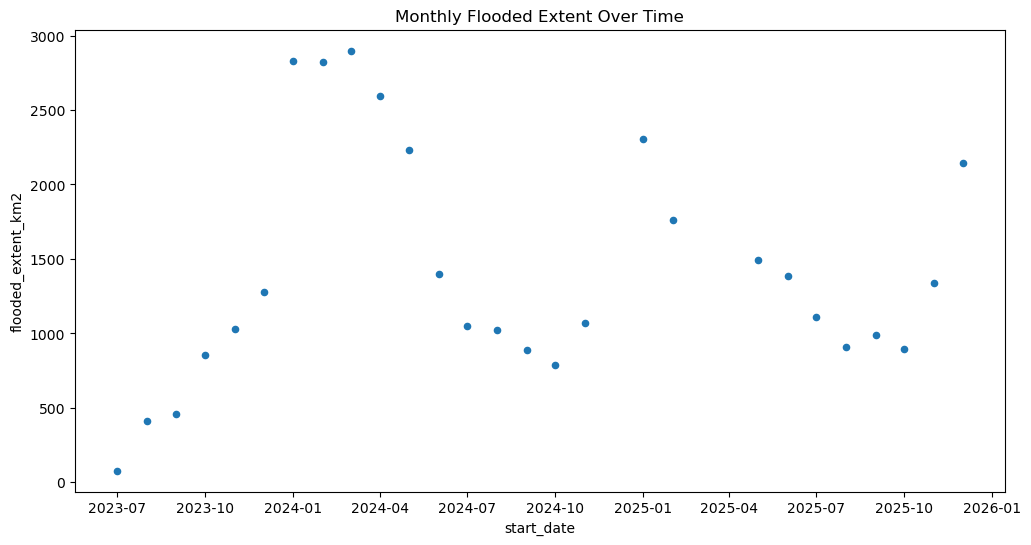

In [107]:
# Now for each weekly raster, compute flooded extent and store in a dataframe
flooded_extent = pd.DataFrame()

for i in range(len(obs_files)):
    obs_file = obs_files[i]
    extent = compute_flooded_extent(obs_file)
    
    flooded_extent.at[i, 'start_date'] = pd.to_datetime(os.path.basename(obs_file)[0:-4].split('_')[3]) 
    flooded_extent.at[i, 'week_dates'] = os.path.basename(obs_file)[0:-4].split('_')[3] + '_' + os.path.basename(obs_file)[0:-4].split('_')[5]
    flooded_extent.at[i, 'flooded_extent_m2'] = extent
    flooded_extent.at[i, 'flooded_extent_km2'] = extent / 1e6

flooded_extent.plot(x='start_date', y='flooded_extent_km2', kind='scatter', figsize=(12,6), legend=False, title=f'{period_str.capitalize()} Flooded Extent Over Time')

In [96]:
point_file = gpd.read_file(r"C:\Users\safr\Documents\github\eo_analysis_usangu\data\shapefiles\height_TS_locations.shp")


c:\Users\safr\.conda\envs\hydroeo\Lib\site-packages\pandas\core\internals\blocks.py:1495: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = casted
c:\Users\safr\.conda\envs\hydroeo\Lib\site-packages\pandas\core\internals\blocks.py:1495: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = casted
c:\Users\safr\.conda\envs\hydroeo\Lib\site-packages\pandas\core\internals\blocks.py:1495: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = casted
c:\Users\safr\.conda\envs\hydroeo\Lib\site-packages\pandas\core\internals\blocks.py:1495: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = casted
c:\Users\safr\.conda\envs\hydroeo\Lib\site-packages\pandas\core\internals\base.py:363: UserWarning: Warning: converting a masked element to nan.
  arr[indexer] = value
c:\Users\safr\.conda\envs\hydroeo\Lib\site-packages\pandas\core\internals\base.py:363: UserWarning: Warning: converting a masked ele

Text(0.5, 0, 'Date')

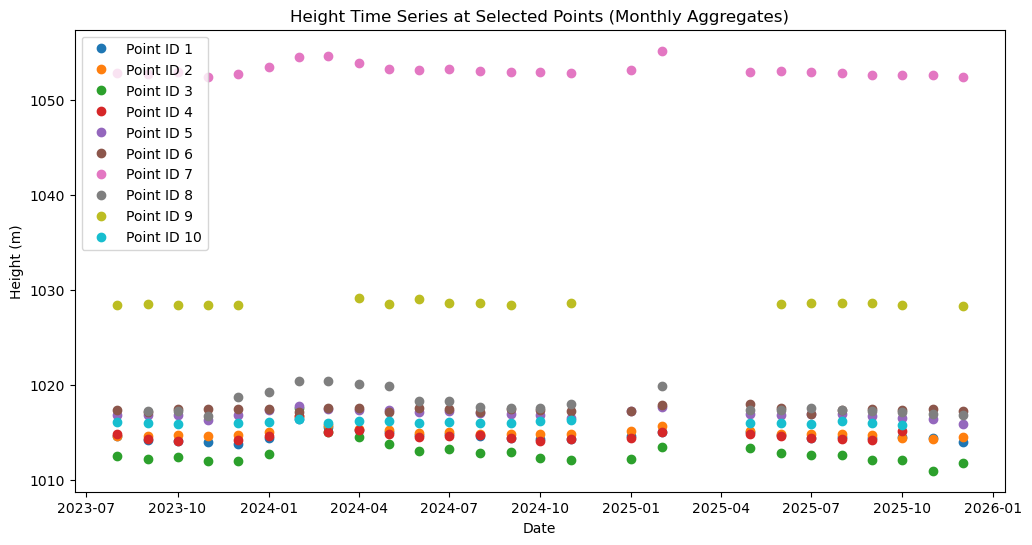

In [97]:
# timeseries of height at a given point
fig, ax = plt.subplots(figsize=(12,6))

for index, row in point_file.iterrows():
    utm_x, utm_y = row.geometry.x, row.geometry.y
    id = row['id']

    height_timeseries = pd.DataFrame()
    for i in range(len(obs_files)):
        obs_file = obs_files[i]
        h = extract_raster_height_from_latlon(utm_y, utm_x, obs_file, buffer_size=50)
        
        height_timeseries.at[i, 'start_date'] = pd.to_datetime(os.path.basename(obs_file)[0:-4].split('_')[3]) 
        height_timeseries.at[i, 'week_dates'] = os.path.basename(obs_file)[0:-4].split('_')[3] + '_' + os.path.basename(obs_file)[0:-4].split('_')[5]
        height_timeseries.at[i, 'height_m'] = h

    ax.plot(height_timeseries['start_date'], height_timeseries['height_m'], marker='o', linestyle='', label=f"Point ID {id}")
ax.legend()
ax.set_ylabel("Height (m)")
ax.set_title(f"Height Time Series at Selected Points ({period_str.capitalize()} Aggregates)")
ax.set_xlabel("Date")